## Authors:
#### Daniel Stöckein (5018039), Alexander Triol (5018451)

In [1]:
# these are our created files
from train import fit 
from datasets import MNIST_Test, MNIST_Train_Datasource
from predict import predict_and_save

# additional packages
import os
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load & Explore Data

In [3]:
# paths
ROOT_DIR = os.path.join('..', 'datasets', 'MixedMNIST', '') # ../datasets/MixedMNIST/
IMAGES_DIR = os.path.join(ROOT_DIR, 'images', '') # ../datasets/MixedMNIST/images/
TRAIN_IMAGES_DIR = os.path.join(IMAGES_DIR, 'train', '')
TEST_IMAGES_DIR = os.path.join(IMAGES_DIR, 'test', '')

# csv files
TRAIN_CSV = ROOT_DIR + 'train.csv'
TRAIN_CSV_PROCESSED = ROOT_DIR + 'train_processed.csv' # this file will have the datasource label split in a separate column
TEST_CSV = ROOT_DIR + 'test.csv'

## 1.1 Train Data with ``class`` as label
- ``ImageFolder`` loads images from a directory where each subdirectory will be interpreted as a class/label
https://pytorch.org/vision/stable/datasets.html
sample: ``image``, ``class``

```
images_train
└───0
│   │   0_003008.png
│   │   1_231516.png
│   │   ...
.
.
.
└───9
│   │   0_031433.png
│   │   1_208115.png
│   │   ...
```

In [4]:
mnist_train = ImageFolder(
    TRAIN_IMAGES_DIR,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ]
    )
)

Show recognized classes

In [5]:
print(mnist_train.class_to_idx)


{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


``ImageFolder`` stores the full path to the image (among other informations)

In [6]:
img_names = [x[0] for x in mnist_train.imgs]
img_names


['..\\datasets\\MixedMNIST\\images\\train\\0\\0_000013.png',
 '..\\datasets\\MixedMNIST\\images\\train\\0\\0_000035.png',
 '..\\datasets\\MixedMNIST\\images\\train\\0\\0_000044.png',
 '..\\datasets\\MixedMNIST\\images\\train\\0\\0_000060.png',
 '..\\datasets\\MixedMNIST\\images\\train\\0\\0_000149.png',
 '..\\datasets\\MixedMNIST\\images\\train\\0\\0_000165.png',
 '..\\datasets\\MixedMNIST\\images\\train\\0\\0_000175.png',
 '..\\datasets\\MixedMNIST\\images\\train\\0\\0_000232.png',
 '..\\datasets\\MixedMNIST\\images\\train\\0\\0_000251.png',
 '..\\datasets\\MixedMNIST\\images\\train\\0\\0_000260.png',
 '..\\datasets\\MixedMNIST\\images\\train\\0\\0_000326.png',
 '..\\datasets\\MixedMNIST\\images\\train\\0\\0_000390.png',
 '..\\datasets\\MixedMNIST\\images\\train\\0\\0_000417.png',
 '..\\datasets\\MixedMNIST\\images\\train\\0\\0_000481.png',
 '..\\datasets\\MixedMNIST\\images\\train\\0\\0_000554.png',
 '..\\datasets\\MixedMNIST\\images\\train\\0\\0_000606.png',
 '..\\datasets\\MixedMNI

Make sure the dataset has correct size and the images the correct shape

In [7]:
print(mnist_train[0][0].shape)
print(len(mnist_train))


torch.Size([1, 28, 28])
240000


## 1.2 Train Data with ``datasource`` as label

This custom dataset is the same as above with the difference, that each image has the ``datasource`` as label. <br>
Perform grayscale + ToTensor transformation. <br>
sample: ``image``, ``datasource``

In [8]:
mnist_train_datasource = MNIST_Train_Datasource(
    csv_file_processed=TRAIN_CSV_PROCESSED,
    csv_file=TRAIN_CSV,
    img_dir=TRAIN_IMAGES_DIR,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ]
    )
)


In [9]:
print(mnist_train_datasource[0][0].shape)
print(len(mnist_train_datasource))


torch.Size([1, 28, 28])
240000


Plot some images with their ``datasource`` label

<Figure size 432x288 with 0 Axes>

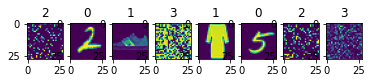

In [10]:
plt.figure()
f, axarr = plt.subplots(1, 8)
for i in range(8):
    image, label = mnist_train_datasource[i]
    axarr[i].imshow(image[0])
    axarr[i].set_title(label)


## 1.3 Test Data
- Since the test images are not structured in subfolders and don't have any indication of their class, we can not use ``ImageFolder``
```
images_test
│   003008.png
│   231516.png
│   069583.png
...
```
sample: ``image``, ``image id``

In [11]:
mnist_test = MNIST_Test(
    csv_file=TEST_CSV,
    img_dir=TEST_IMAGES_DIR,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ]
    )
)


In [12]:
print(mnist_test[0][0].shape)
print(len(mnist_test))


torch.Size([1, 28, 28])
40000


We can simply get all information by calling the ``mnist_test`` attributes

In [13]:
mnist_test.csv.image


0        240000.png
1        240001.png
2        240002.png
3        240003.png
4        240004.png
            ...    
39995    279995.png
39996    279996.png
39997    279997.png
39998    279998.png
39999    279999.png
Name: image, Length: 40000, dtype: object

... or the information for a single image, e.g. the ``image_id``

In [14]:
mnist_test[0][1]


240000

# 2. Model definitions
Our goal is to train 3 different networks and to compare their results. <br>

**Multiclass classifiers** <br>
Since we only need to predict the ``class`` label for each image in the give test dataset, we will train 3 multiclass classifiers (ignoring the fact that we have an additional label ``datasource``). Another reason to follow this approach is because we have a lot of samples (240.000 images) and we think this should be enough data to get decent results.
- [CNN_simple](#cnn_simple): The first network will be a relative simple CNN.
- [CNN_deep](#cnn_deep): The second network will be a more deeper and complex CNN. We will basically stack a bunch of conv layers and use batch normalization.
- [ResNet](#resnet): The second network will be a ResNet. This should allow us to train even more deep networks.

## 2.1 CNN
<a id='cnn'></a>

(Reminder):
- The ``out_channels`` is what convolution will produce so these are the **number of filters**. They are usually choosen by intuition.
- Input: $ I $, Filters: $ F $, Padding $ P $, Stride: $ S $
- Formula: $ (((I-F+2*P )/S)+1) $

### 2.1.1 Simple CNN
<a id='cnn_simple'></a>

We started with a simple CNN with 2 conv layers. We choosed a kernel_size of 5 for each conv-layer, which will reduce the images dimension. After that, a maxpool layer is applied with a kernel_size of 5 + stride of 2, which will reduce the dimensions of the feature maps. Lastly, we apply dropout to prevent overfitting, if facing more features than examples. Results can be seen in section [5. Experiments](#exp)

In [15]:
class CNN_simple(nn.Module):
    def __init__(self, in_channels, num_classes, out_channels):
        super(CNN_simple, self).__init__()
        
        self.net = nn.Sequential(
            # 1st conv layer
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels[0], kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2),
            
            # 2nd conv layer
            nn.Conv2d(out_channels[0], out_channels[1], 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2),

            nn.Dropout(0.25),
        )

        self.fc_out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(out_channels[1], num_classes)
        )

    def forward(self, x):
        x = self.net(x)
        x = self.fc_out(x)

        return x


In [16]:
print(CNN_simple(1, 10, [8, 16]))

CNN_simple(
  (net): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.25, inplace=False)
  )
  (fc_out): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16, out_features=10, bias=True)
  )
)


### 2.1.2 Deeper CNN
<a id='cnn_deep'></a>

In this network we introduce batch normalization to normalize the output from conv layer. According to Andrew Ng, batch normal should be preferably applied before activation function: https://youtu.be/tNIpEZLv_eg During training, the batch-norm parameters will be optimized aswell, so the weights within the network dont become inbalanced. Hopefully this will also increase training speed as the network optimizes on normalized data on all layers.

Results can be seen here [5. Experiments](#exp)

In [17]:
class CNN_deep(nn.Module):
    def __init__(self, in_channels, num_classes, out_channels):
        super(CNN_deep, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            # 1st conv layer
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels[0], kernel_size=3, padding=1), # keep spatial dimension 28x28
            nn.BatchNorm2d(num_features=out_channels[0]),
            nn.ReLU(),
            
            # 2nd conv layer
            nn.Conv2d(out_channels[0], out_channels[0], 3, padding=1), # keep spatial dimension 28x28
            nn.BatchNorm2d(out_channels[0]),
            nn.ReLU(), 
            
            # 3rd conv layer
            nn.Conv2d(out_channels[0], out_channels[0], 3, stride=2, padding=1), # 14x14 - stride to reduce amount of computation
            nn.BatchNorm2d(out_channels[0]),
            nn.ReLU(),  
            
            nn.MaxPool2d(kernel_size=2, stride=2), # 7x7 - pooling will also reduce output size
            nn.Dropout(0.25)
        )

        self.conv_block2 = nn.Sequential(
            # 4th conv layer
            nn.Conv2d(out_channels[0], out_channels[1], 3, padding=1),
            nn.BatchNorm2d(out_channels[1]),
            nn.ReLU(),
            
            # 5th conv layer
            nn.Conv2d(out_channels[1], out_channels[1], 3, padding=1),
            nn.BatchNorm2d(out_channels[1]),
            nn.ReLU(),
            
            # 6th conv layer
            nn.Conv2d(out_channels[1], out_channels[1], 3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels[1]),
            nn.ReLU(),
            
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        self.conv_block3 = nn.Sequential(
            # 7th conv layer
            nn.Conv2d(out_channels[1], out_channels[2], 3, padding=1),
            nn.BatchNorm2d(out_channels[2]),
            nn.ReLU(),
            
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        self.fc_out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(out_channels[2], num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        x = self.fc_out(x)

        return x


In [18]:
print(CNN_deep(1, 10, [8,16,32]))

CNN_deep(
  (conv_block1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.25, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm

## 2.2 ResNet
<a id='resnet'></a>

Now we implemented a ResNet. The advantage here is, that we can increase network depth and to avoid negative outcomes at the same time. The following code implements the residual blocks with skip connections such that the input passed via the shortcut matches the dimensions of the main path's output, which allows the network to learn identity functions. What this means is that the input to the following layer is passed directly or as a shortcut. Skip connection is basically the identity mapping where the input from previous layer is added directly to the output of the other layer. 

Such a residual block is illustrated below:
<img src="https://raw.githubusercontent.com/rasbt/stat453-deep-learning-ss21/52667a6b6634ddeb7564c34c1d8737ea5ef3c94b/L14/2-resnet-ex/resnet-ex-1-1.png" />

Results can be seen here [5. Experiments](#exp)

In [19]:
class ResNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        
        self.block_1 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=1,
                                out_channels=4,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=0),
                torch.nn.BatchNorm2d(4),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(in_channels=4,
                                out_channels=1,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.BatchNorm2d(1)
        )
        
        self.block_2 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=1,
                                out_channels=4,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=0),
                torch.nn.BatchNorm2d(4),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(in_channels=4,
                                out_channels=1,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.BatchNorm2d(1)
        )
        
        self.block_3 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=1,
                                out_channels=4,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=0),
                torch.nn.BatchNorm2d(4),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(in_channels=4,
                                out_channels=1,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.BatchNorm2d(1)
        )
        
        self.block_4 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=1,
                                out_channels=4,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=0),
                torch.nn.BatchNorm2d(4),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(in_channels=4,
                                out_channels=1,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.BatchNorm2d(1)
        )
       
        self.linear_1 = torch.nn.Linear(1*28*28, num_classes)
        
    def forward(self, x):
        
        before_block = x
        
        x = self.block_1(x)
        
        x = torch.nn.functional.relu(x + before_block)
        
        #before_block = x
        #x = self.block_2(x)
        #x = torch.nn.functional.relu(x + before_block)
        
        #before_block = x
        #x = self.block_3(x)
        #x = torch.nn.functional.relu(x + before_block)
        
        #before_block = x
        #x = self.block_4(x)
        #x = torch.nn.functional.relu(x + before_block)
        
        out = self.linear_1(x.view(-1,  1*28*28))
        return out

In [20]:
print(ResNet(10))

ResNet(
  (block_1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block_2): Sequential(
    (0): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block_3): Sequential(
    (0): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1,

# 3. Training
- We going to print the training accuracy and the training time in seconds for each model
- No test accuracy, since this will be calculated by Kaggle.

## 3.1 Simple CNN

In [21]:
batch_size = 100
epochs = 30
learning_rate = 0.08

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
# Don't shuffle test dataset as it will destroy image<->image_id relation
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [22]:
cnn_simple = CNN_simple(in_channels=1, num_classes=10, out_channels=[32, 64])

In [31]:
fit(
    model=cnn_simple,
    train_loader=train_loader,
    epochs=epochs,
    learning_rate=learning_rate,
    device=device
)

Training on: cuda 

Epoch: 1/30 | Batch 0/2400 | Cost: 2.3210
Epoch: 1/30 | Batch 250/2400 | Cost: 1.9579
Epoch: 1/30 | Batch 500/2400 | Cost: 1.4069
Epoch: 1/30 | Batch 750/2400 | Cost: 1.2727
Epoch: 1/30 | Batch 1000/2400 | Cost: 1.1438
Epoch: 1/30 | Batch 1250/2400 | Cost: 0.8542
Epoch: 1/30 | Batch 1500/2400 | Cost: 0.8455
Epoch: 1/30 | Batch 1750/2400 | Cost: 0.8984
Epoch: 1/30 | Batch 2000/2400 | Cost: 0.6799
Epoch: 1/30 | Batch 2250/2400 | Cost: 0.7812
Training: Correct[194155] | Wrong[45845] | Accuracy[80.90%] 

Epoch: 2/30 | Batch 0/2400 | Cost: 0.8228
Epoch: 2/30 | Batch 250/2400 | Cost: 0.5590
Epoch: 2/30 | Batch 500/2400 | Cost: 0.5618
Epoch: 2/30 | Batch 750/2400 | Cost: 0.5341
Epoch: 2/30 | Batch 1000/2400 | Cost: 0.5240
Epoch: 2/30 | Batch 1250/2400 | Cost: 0.5386
Epoch: 2/30 | Batch 1500/2400 | Cost: 0.4916
Epoch: 2/30 | Batch 1750/2400 | Cost: 0.6706
Epoch: 2/30 | Batch 2000/2400 | Cost: 0.4269
Epoch: 2/30 | Batch 2250/2400 | Cost: 0.4111
Training: Correct[204503] | Wr

Epoch: 17/30 | Batch 250/2400 | Cost: 0.3959
Epoch: 17/30 | Batch 500/2400 | Cost: 0.2375
Epoch: 17/30 | Batch 750/2400 | Cost: 0.2340
Epoch: 17/30 | Batch 1000/2400 | Cost: 0.4243
Epoch: 17/30 | Batch 1250/2400 | Cost: 0.2313
Epoch: 17/30 | Batch 1500/2400 | Cost: 0.2502
Epoch: 17/30 | Batch 1750/2400 | Cost: 0.4807
Epoch: 17/30 | Batch 2000/2400 | Cost: 0.3929
Epoch: 17/30 | Batch 2250/2400 | Cost: 0.2409
Training: Correct[219279] | Wrong[20721] | Accuracy[91.37%] 

Epoch: 18/30 | Batch 0/2400 | Cost: 0.2927
Epoch: 18/30 | Batch 250/2400 | Cost: 0.2891
Epoch: 18/30 | Batch 500/2400 | Cost: 0.2781
Epoch: 18/30 | Batch 750/2400 | Cost: 0.3807
Epoch: 18/30 | Batch 1000/2400 | Cost: 0.3474
Epoch: 18/30 | Batch 1250/2400 | Cost: 0.2741
Epoch: 18/30 | Batch 1500/2400 | Cost: 0.2790
Epoch: 18/30 | Batch 1750/2400 | Cost: 0.2615
Epoch: 18/30 | Batch 2000/2400 | Cost: 0.4689
Epoch: 18/30 | Batch 2250/2400 | Cost: 0.2590
Training: Correct[219213] | Wrong[20787] | Accuracy[91.34%] 

Epoch: 19/3

## 3.2 Deeper CNN

In [23]:
batch_size = 100
epochs = 30
learning_rate = 0.05

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
# Don't shuffle test dataset as it will destroy image<->image_id relation
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [24]:
cnn_deep = CNN_deep(in_channels=1, num_classes=10, out_channels=[32, 64, 128])

In [51]:
fit(
    model=cnn_deep,
    train_loader=train_loader,
    epochs=epochs,
    learning_rate=learning_rate,
    device=device
)


Training on: cuda 

Epoch: 1/30 | Batch 0/2400 | Cost: 2.5088
Epoch: 1/30 | Batch 250/2400 | Cost: 0.5819
Epoch: 1/30 | Batch 500/2400 | Cost: 0.7098
Epoch: 1/30 | Batch 750/2400 | Cost: 0.5414
Epoch: 1/30 | Batch 1000/2400 | Cost: 0.4817
Epoch: 1/30 | Batch 1250/2400 | Cost: 0.4282
Epoch: 1/30 | Batch 1500/2400 | Cost: 0.2707
Epoch: 1/30 | Batch 1750/2400 | Cost: 0.3952
Epoch: 1/30 | Batch 2000/2400 | Cost: 0.3543
Epoch: 1/30 | Batch 2250/2400 | Cost: 0.4558
Training: Correct[214699] | Wrong[25301] | Accuracy[89.46%] 

Epoch: 2/30 | Batch 0/2400 | Cost: 0.4640
Epoch: 2/30 | Batch 250/2400 | Cost: 0.4625
Epoch: 2/30 | Batch 500/2400 | Cost: 0.2735
Epoch: 2/30 | Batch 750/2400 | Cost: 0.3534
Epoch: 2/30 | Batch 1000/2400 | Cost: 0.4292
Epoch: 2/30 | Batch 1250/2400 | Cost: 0.3437
Epoch: 2/30 | Batch 1500/2400 | Cost: 0.2444
Epoch: 2/30 | Batch 1750/2400 | Cost: 0.3576
Epoch: 2/30 | Batch 2000/2400 | Cost: 0.3025
Epoch: 2/30 | Batch 2250/2400 | Cost: 0.2577
Training: Correct[219009] | Wr

Epoch: 17/30 | Batch 250/2400 | Cost: 0.2204
Epoch: 17/30 | Batch 500/2400 | Cost: 0.1740
Epoch: 17/30 | Batch 750/2400 | Cost: 0.1327
Epoch: 17/30 | Batch 1000/2400 | Cost: 0.1176
Epoch: 17/30 | Batch 1250/2400 | Cost: 0.2252
Epoch: 17/30 | Batch 1500/2400 | Cost: 0.1664
Epoch: 17/30 | Batch 1750/2400 | Cost: 0.0781
Epoch: 17/30 | Batch 2000/2400 | Cost: 0.1564
Epoch: 17/30 | Batch 2250/2400 | Cost: 0.1861
Training: Correct[228911] | Wrong[11089] | Accuracy[95.38%] 

Epoch: 18/30 | Batch 0/2400 | Cost: 0.1636
Epoch: 18/30 | Batch 250/2400 | Cost: 0.1414
Epoch: 18/30 | Batch 500/2400 | Cost: 0.2529
Epoch: 18/30 | Batch 750/2400 | Cost: 0.1977
Epoch: 18/30 | Batch 1000/2400 | Cost: 0.2096
Epoch: 18/30 | Batch 1250/2400 | Cost: 0.1105
Epoch: 18/30 | Batch 1500/2400 | Cost: 0.2574
Epoch: 18/30 | Batch 1750/2400 | Cost: 0.2295
Epoch: 18/30 | Batch 2000/2400 | Cost: 0.1980
Epoch: 18/30 | Batch 2250/2400 | Cost: 0.2804
Training: Correct[229165] | Wrong[10835] | Accuracy[95.49%] 

Epoch: 19/3

## 3.3 ResNet

In [25]:
batch_size = 100
epochs = 30
learning_rate = 0.05

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
# Don't shuffle test dataset as it will destroy image<->image_id relation
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [26]:
resnet = ResNet(num_classes=10)

In [27]:
fit(
    model=resnet,
    train_loader=train_loader,
    epochs=epochs,
    learning_rate=learning_rate,
    device=device
)

Training on: cuda 

Epoch: 1/30 | Batch 0/2400 | Cost: 2.4244
Epoch: 1/30 | Batch 250/2400 | Cost: 0.8375
Epoch: 1/30 | Batch 500/2400 | Cost: 0.5766
Epoch: 1/30 | Batch 750/2400 | Cost: 0.5330
Epoch: 1/30 | Batch 1000/2400 | Cost: 0.4855
Epoch: 1/30 | Batch 1250/2400 | Cost: 0.5711
Epoch: 1/30 | Batch 1500/2400 | Cost: 0.6659
Epoch: 1/30 | Batch 1750/2400 | Cost: 0.7176
Epoch: 1/30 | Batch 2000/2400 | Cost: 0.5652
Epoch: 1/30 | Batch 2250/2400 | Cost: 0.6261
Training: Correct[201532] | Wrong[38468] | Accuracy[83.97%] 

Epoch: 2/30 | Batch 0/2400 | Cost: 0.4900
Epoch: 2/30 | Batch 250/2400 | Cost: 0.5009
Epoch: 2/30 | Batch 500/2400 | Cost: 0.4889
Epoch: 2/30 | Batch 750/2400 | Cost: 0.7199
Epoch: 2/30 | Batch 1000/2400 | Cost: 0.4549
Epoch: 2/30 | Batch 1250/2400 | Cost: 0.5953
Epoch: 2/30 | Batch 1500/2400 | Cost: 0.5072
Epoch: 2/30 | Batch 1750/2400 | Cost: 0.4984
Epoch: 2/30 | Batch 2000/2400 | Cost: 0.5234
Epoch: 2/30 | Batch 2250/2400 | Cost: 0.4346
Training: Correct[203508] | Wr

Epoch: 17/30 | Batch 250/2400 | Cost: 0.3999
Epoch: 17/30 | Batch 500/2400 | Cost: 0.5279
Epoch: 17/30 | Batch 750/2400 | Cost: 0.1930
Epoch: 17/30 | Batch 1000/2400 | Cost: 0.1999
Epoch: 17/30 | Batch 1250/2400 | Cost: 0.4355
Epoch: 17/30 | Batch 1500/2400 | Cost: 0.4680
Epoch: 17/30 | Batch 1750/2400 | Cost: 0.4032
Epoch: 17/30 | Batch 2000/2400 | Cost: 0.4163
Epoch: 17/30 | Batch 2250/2400 | Cost: 0.4352
Training: Correct[209089] | Wrong[30911] | Accuracy[87.12%] 

Epoch: 18/30 | Batch 0/2400 | Cost: 0.4052
Epoch: 18/30 | Batch 250/2400 | Cost: 0.3553
Epoch: 18/30 | Batch 500/2400 | Cost: 0.3776
Epoch: 18/30 | Batch 750/2400 | Cost: 0.3853
Epoch: 18/30 | Batch 1000/2400 | Cost: 0.2721
Epoch: 18/30 | Batch 1250/2400 | Cost: 0.4774
Epoch: 18/30 | Batch 1500/2400 | Cost: 0.2989
Epoch: 18/30 | Batch 1750/2400 | Cost: 0.2484
Epoch: 18/30 | Batch 2000/2400 | Cost: 0.3616
Epoch: 18/30 | Batch 2250/2400 | Cost: 0.5469
Training: Correct[208753] | Wrong[31247] | Accuracy[86.98%] 

Epoch: 19/3

# 4. Predict
Now we are going to use our trained models to predict the ``class`` label for the test dataset. <br>
The following function returns a list with the predicted classes in the shape of: ``[id, classification]``


In [35]:
predict_and_save(
    model=cnn_simple, 
    test_loader=test_loader,
    path=ROOT_DIR,
    device=device
)

File saved under: ..\datasets\MixedMNIST\submission_CNN_simple_2022-01-23_125630.csv


In [53]:
predict_and_save(
    model=cnn_deep, 
    test_loader=test_loader,
    path=ROOT_DIR,
    device=device
)

File saved under: ..\datasets\MixedMNIST\submission_CNN_deep_2022-01-23_162643.csv


In [28]:
predict_and_save(
    model=resnet, 
    test_loader=test_loader,
    path=ROOT_DIR,
    device=device
)

File saved under: ..\datasets\MixedMNIST\submission_ResNet_2022-01-29_151540.csv


# 5. Experiments
<a id='exp'></a>

| Model | Train Accuracy | Test Accuracy (Kaggle) | Training time (seconds) | Hyperparameters (batch_size, epochs, lr) | Date | Note |
| - | - | - | - | - | - | - |
| [CNN_simple](#cnn_simple) | 77.12 % | not uploaded | 978s | 100, 10, 0.1 | 2022-01-08 14:26 | First net, just to try if everything works. |
| [CNN_simple](#cnn_simple) | 91.85 % | 89.89 % (Round 1) | 2936s | 100, 30, 0.08 | 2022-01-10 16:04 | Added Dropout and increased Kernel size to 5, also increased the number of output channels to 32 and 64. The model stagnated at around 92% training accuracy and didnt increase for several epochs |
| [CNN_deep](#cnn_deep) | 89.16 % | 88.91 % (Round 2) | 1016s | 100, 10, 0.08 | 2022-01-15 17:42 | First try on the deeper net, with output channels 8, 16, 32. Batch norm. after ReLU |
| [CNN_deep](#cnn_deep) | 87.66 % | 87.48 % (Round 2) | 1043s | 100, 10, 0.08 | 2022-01-16 12:58 | Applied batch norm. before ReLU |
| [CNN_deep](#cnn_deep) | 95.67 % | 93.77 % (Round 2) | 987s | 100, 10, 0.08 | 2022-01-18 13:20 | Changed output channels to 32, 64, 128 |
| [CNN_deep](#cnn_deep) | 96.64 % | 94.22 % (Round 3) | 3061s | 100, 30, 0.05 | 2022-01-22 13:54 | Changed hyperparameters |
| [ResNet](#resnet)|86.58 %| 85.82 % (Round 3) | 2195s | 100,  5, 0.01 | 2022-01-26 12:44 | First try |
| [ResNet](#resnet)|87.48 %| 86.57 % (Round 3) | 2899s | 100,  30, 0.05 | 2022-01-29 15:12 | Changed hyperparameters |


# 6. Summary

CNN: The simple CNN with two conv layers was pretty straight forward to implement. 77% accuracy on the training data didnt seem too bad but there was much room for improvement. With increased kernel size and more output channels, this simple model already reached a good training accuracy of 91.85%. In the deeper CNN we basically stacked a few conv layers and used batch norm which speed up the training time. The best accuracy on the test data was reached with 32, 64 and 128 output channels. We tried several batch sizes aswell but 100 seemed to be the best.

ResNet: Our ResNet took by far the longest amount of time to train (even on GPU). Our simple implementation could not reach better results than our deep CNN. That is because the ResNet does not have multiple conv-layers and its not very deep. We tried to train on a deeper ResNet with multiple blocks but it took way to long.